In [97]:
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)
import matplotlib.pyplot as plt

# reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [98]:
paths = [
    "C:/Users/mahar/Downloads/Capstone for Models/cpz_station_timeseries_2021_yearly_15min.parquet",
    "C:/Users/mahar/Downloads/Capstone for Models/cpz_station_timeseries_2022_yearly_15min.parquet",
    "C:/Users/mahar/Downloads/Capstone for Models/cpz_station_timeseries_2023_yearly_15min.parquet",
    "C:/Users/mahar/Downloads/Capstone for Models/cpz_station_timeseries_2024_yearly_15min.parquet"
]


In [99]:
dfs = []
for p in parquet_paths:
    dfp = (
        pd.read_parquet(p, engine="pyarrow")
          .rename(columns={
              "time_bucket":     "ds",
              "start_station_id":"station_id",
              "booking_count":   "y"
          })
    )
    dfp["ds"] = pd.to_datetime(dfp["ds"])
    dfs.append(dfp)
rides_df = pd.concat(dfs, ignore_index=True)

# filter to target station
station_id = "4818.03"
rides_df = rides_df[rides_df["station_id"].astype(str) == station_id].copy()

# aggregate to daily totals
rides_df["ds"] = rides_df["ds"].dt.floor("D")
rides_daily = (
    rides_df
      .groupby("ds", as_index=False)["y"]
      .sum()
)


In [100]:
# === 2. Load Static Urban & Weather Features ===
urban_df = pd.read_csv("C:/Users/mahar/Downloads/Final_Urban_Feaatures_Merged_csv.csv",
                       header=1)
urban_df["station_id"] = urban_df["station_id"].astype(str)
uf = (
    urban_df
      .set_index("station_id")
      .loc[station_id]
      .drop("station_id", errors="ignore")
      .to_dict()
)

In [101]:
# === 3. Load & Prepare Weather Data ===
weather_df = (
    pd.read_csv("C:/Users/mahar/Downloads/Capstone for Models/final_weather_dataset (1) (1).csv",
                parse_dates=["DATE"])
      .rename(columns={"DATE":"ds"})
)


In [102]:
# === 4. Merge Daily Rides + Weather + Static Features ===
df = (
    rides_daily
      .merge(weather_df, on="ds", how="left")
      .assign(**uf)
      .sort_values("ds")
      .reset_index(drop=True)
)

# one-hot encode weather category
if "WEATHER_CATEGORY" in df.columns:
    df = pd.get_dummies(df,
                        columns=["WEATHER_CATEGORY"],
                        prefix="WEATHER_CATEGORY")

# fill any remaining gaps
df.ffill(inplace=True)
df.bfill(inplace=True)
df.fillna(0, inplace=True)


In [103]:
# === 5. Add Date‑Based Seasonality Features ===
df["dow"]     = df["ds"].dt.dayofweek
df["mth"]     = df["ds"].dt.month
df["dow_sin"] = np.sin(2*np.pi*df["dow"] / 7)
df["dow_cos"] = np.cos(2*np.pi*df["dow"] / 7)
df["mth_sin"] = np.sin(2*np.pi*(df["mth"]-1) / 12)
df["mth_cos"] = np.cos(2*np.pi*(df["mth"]-1) / 12)
df.drop(columns=["dow","mth"], inplace=True)


In [104]:
# === 6. Scale & Train/Val/Test Split ===
dates   = df["ds"].values
y_raw   = df["y"].values.reshape(-1,1)
cov_raw = df.drop(columns=["ds","y"], errors="ignore").values

y_scaler   = StandardScaler();    target     = y_scaler.fit_transform(y_raw)
cov_scaler = StandardScaler();    covariates = cov_scaler.fit_transform(cov_raw)

n         = len(target)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)

train_y, val_y, test_y = (
    target[:train_end],
    target[train_end:val_end],
    target[val_end:]
)
train_c, val_c, test_c = (
    covariates[:train_end],
    covariates[train_end:val_end],
    covariates[val_end:]
)


In [105]:
# === 7. Sequence Dataset & DataLoader ===
context, batch_size = 30, 32

class SeqDataset(Dataset):
    def __init__(self, y, c, ctx):
        self.y, self.c, self.ctx = y, c, ctx
    def __len__(self):
        return len(self.y) - self.ctx
    def __getitem__(self, i):
        seq_y = self.y[i : i+self.ctx]
        seq_c = self.c[i : i+self.ctx]
        x = np.concatenate([seq_y, seq_c], axis=1)
        y_true = self.y[i+self.ctx, 0]
        return (torch.tensor(x, dtype=torch.float32),
                torch.tensor(y_true, dtype=torch.float32))

train_dl = DataLoader(SeqDataset(train_y, train_c, context),
                      batch_size=batch_size, shuffle=True)
val_dl   = DataLoader(SeqDataset(val_y,   val_c,   context),
                      batch_size=batch_size)
test_ds  = SeqDataset(test_y, test_c, context)


In [106]:
# === 8. Positional Encoding & Transformer Model ===
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=365*5):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float()
                        * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerForecast(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4,
                 num_layers=2, dim_feed=128, drop=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc     = PositionalEncoding(d_model)
        layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feed, drop, batch_first=True
        )
        self.encoder  = nn.TransformerEncoder(layer, num_layers)
        self.out_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)
        h = self.encoder(x)
        return self.out_proj(h[:,-1,:]).squeeze(-1)

input_dim = 1 + covariates.shape[1]
model     = TransformerForecast(input_dim).to(device)
opt       = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.MSELoss()


In [107]:
# === 9. Training Loop ===
epochs = 20
for ep in range(1, epochs+1):
    model.train()
    tr_losses = []
    for x,y in train_dl:
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        loss = loss_fn(model(x), y)
        loss.backward()
        opt.step()
        tr_losses.append(loss.item())
    model.eval()
    vl_losses = []
    with torch.no_grad():
        for x,y in val_dl:
            x,y = x.to(device), y.to(device)
            vl_losses.append(loss_fn(model(x), y).item())
    print(f"Epoch {ep:02d} ▶ train_loss: {np.mean(tr_losses):.4f} — val_loss: {np.mean(vl_losses):.4f}")


Epoch 01 ▶ train_loss: 0.6427 — val_loss: 0.4372
Epoch 02 ▶ train_loss: 0.5478 — val_loss: 0.4887
Epoch 03 ▶ train_loss: 0.5881 — val_loss: 0.4835
Epoch 04 ▶ train_loss: 0.6010 — val_loss: 0.5395
Epoch 05 ▶ train_loss: 0.5436 — val_loss: 0.5039
Epoch 06 ▶ train_loss: 0.5324 — val_loss: 0.4646
Epoch 07 ▶ train_loss: 0.5009 — val_loss: 0.4668
Epoch 08 ▶ train_loss: 0.5280 — val_loss: 0.5167
Epoch 09 ▶ train_loss: 0.5163 — val_loss: 0.4360
Epoch 10 ▶ train_loss: 0.4881 — val_loss: 0.4896
Epoch 11 ▶ train_loss: 0.4925 — val_loss: 0.4696
Epoch 12 ▶ train_loss: 0.4856 — val_loss: 0.4459
Epoch 13 ▶ train_loss: 0.4718 — val_loss: 0.4808
Epoch 14 ▶ train_loss: 0.4542 — val_loss: 0.4917
Epoch 15 ▶ train_loss: 0.4736 — val_loss: 0.4831
Epoch 16 ▶ train_loss: 0.4564 — val_loss: 0.4889
Epoch 17 ▶ train_loss: 0.4471 — val_loss: 0.5207
Epoch 18 ▶ train_loss: 0.4281 — val_loss: 0.5258
Epoch 19 ▶ train_loss: 0.4398 — val_loss: 0.5035
Epoch 20 ▶ train_loss: 0.4123 — val_loss: 0.4741


In [108]:
look_ahead = 90

# 1) Roll‑forward forecast (assuming ctx_seq, future_cov, model, context exist)
future_preds = []
model.eval()
with torch.no_grad():
    for t in range(look_ahead):
        inp = torch.tensor(ctx_seq[-context:], dtype=torch.float32) \
                   .unsqueeze(0).to(device)
        out = model(inp).cpu().numpy().ravel()[0]
        future_preds.append(out)
        ctx_seq = np.vstack([ctx_seq, np.concatenate([[out], future_cov[t]])])

future_vals = y_scaler.inverse_transform(
    np.array(future_preds).reshape(-1,1)
).ravel()
future_vals = np.maximum(future_vals, 0)  # clamp negatives

# 2) Test‑set preds & metrics (assuming test_ds exists)
test_preds, test_trues = [], []
with torch.no_grad():
    for i in range(len(test_ds)):
        x, y_true = test_ds[i]
        p = model(x.unsqueeze(0).to(device)).cpu().numpy().ravel()[0]
        test_preds.append(p)
        test_trues.append(y_true.item())

true_test = y_scaler.inverse_transform(
    np.array(test_trues).reshape(-1,1)
).ravel()
pred_test = y_scaler.inverse_transform(
    np.array(test_preds).reshape(-1,1)
).ravel()

mae  = mean_absolute_error(true_test, pred_test)
mse  = mean_squared_error(true_test, pred_test)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(true_test, pred_test)*100

print("🔍 Test‑Set Metrics:")
print(f" MAE  = {mae:.3f}")
print(f" MSE  = {mse:.3f}")
print(f" RMSE = {rmse:.3f}")
print(f" MAPE = {mape:.2f}%\n")

🔍 Test‑Set Metrics:
 MAE  = 5.542
 MSE  = 50.037
 RMSE = 7.074
 MAPE = 28.41%



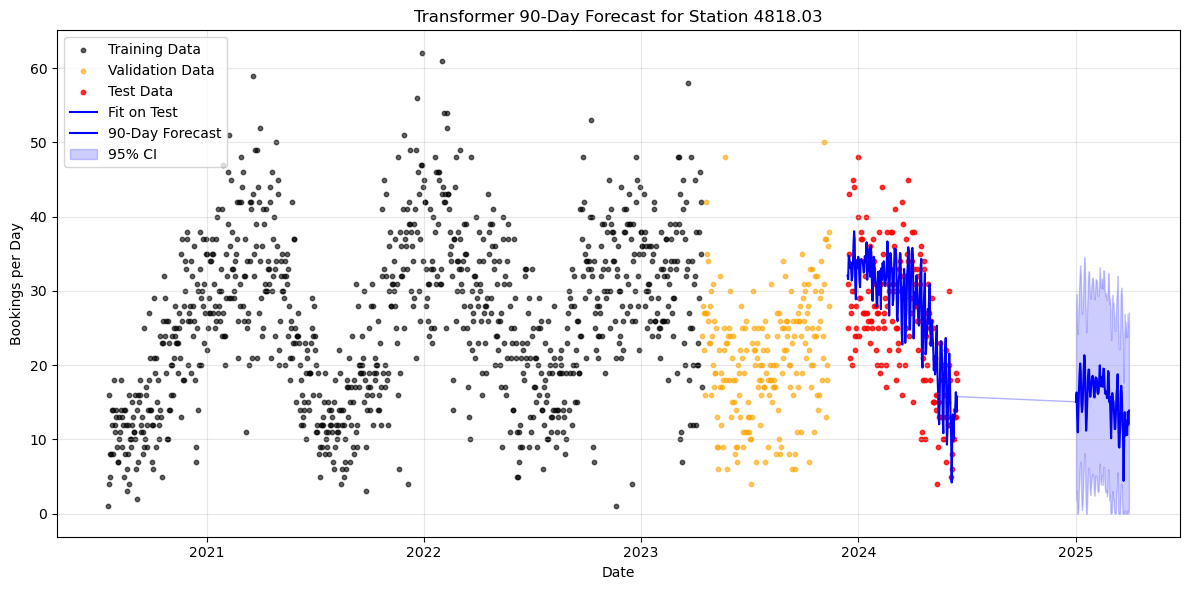

In [109]:
# --- 2) Build date/value arrays ---
dates_all    = pd.to_datetime(df_daily["ds"])
train_dates  = dates_all.iloc[:train_end]
val_dates    = dates_all.iloc[train_end:val_end]
test_dates   = dates_all.iloc[val_end+context : val_end+context+len(pred_test)]
future_dates = pd.date_range(dates_all.iloc[-1] + pd.Timedelta(days=1),
                             periods=look_ahead)

train_vals = y_scaler.inverse_transform(target[:train_end]).ravel()
val_vals   = y_scaler.inverse_transform(target[train_end:val_end]).ravel()

# --- 3) Plot ---
plt.figure(figsize=(12,6))

# scatter raw data
plt.scatter(train_dates, train_vals, s=10, c="black",  label="Training Data", alpha=0.6)
plt.scatter(val_dates,   val_vals,   s=10, c="orange", label="Validation Data", alpha=0.6)
plt.scatter(test_dates,  true_test,  s=10, c="red",    label="Test Data", alpha=0.8)

# 3a) how model fit on test
plt.plot(test_dates, pred_test, "-", c="blue", lw=1.5, label="Fit on Test")

# 3b) faint connector to first forecast point
conn_x = [ test_dates.values[-1], future_dates.values[0] ]
conn_y = [ pred_test[-1],        future_vals[0]     ]
plt.plot(conn_x, conn_y, "-", c="blue", alpha=0.3, lw=1)

# 3c) 90‑day forecast
plt.plot(future_dates, future_vals, "-", c="blue", lw=1.5, label=f"{look_ahead}-Day Forecast")

# 3d) CI shading under future only
ci_low  = np.maximum(future_vals - 1.96 * sigma, 0)
ci_high = future_vals + 1.96 * sigma
plt.fill_between(future_dates, ci_low, ci_high,
                 color="blue", alpha=0.2, label="95% CI")

# 4) Styling
plt.title(f"Transformer 90‑Day Forecast for Station {station_id}")
plt.xlabel("Date"); plt.ylabel("Bookings per Day")
plt.legend(loc="upper left"); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

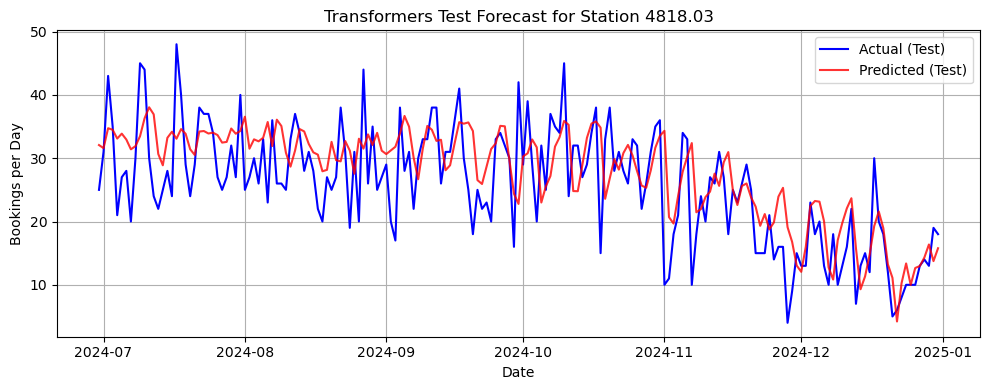

In [112]:
# 9. Plot Actual vs Predicted
test_dates = dates[val_end + context:]
plt.figure(figsize=(10,4))
plt.plot(test_dates, true_test, label="Actual (Test)", color="blue")
plt.plot(test_dates, pred_test, label="Predicted (Test)", color="red", alpha=0.8)
plt.title(f"Transformers Test Forecast for Station {station_id}")
plt.xlabel("Date"); plt.ylabel("Bookings per Day")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()